In [1]:
from cellpose import models
from cellpose import core
from cellpose import dynamics
import os
from u_net_clean import get_images_masks
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from dynamics_model import get_data
from sklearn.model_selection import train_test_split

/opt/anaconda3/envs/unetenv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def reg_data(imgs, cellpose_model):
    #get the cellprobs as those will be the Xs
    #get the cellpose masks as those will be the Ys

    

    masks, flows, styles = model.eval(imgs,channels=[[0,0]],cellprob_threshold=0.0)

    print('len masks',len(masks))

    plt.imshow(masks[0])
    plt.show()

    #print(flows)
    #print('\n')
    #print(flows[0])

    cellprobs = []
    for i in range(len(flows)):
        cellprobs.append(flows[i][2])

    binary_masks = []
    for i in range(len(masks)):
        binary_masks.append(np.where(masks[i]>0,1,0))

    plt.subplot(2,2,1)
    plt.imshow(cellprobs[0])

    plt.subplot(2,2,2)
    plt.imshow(binary_masks[0])

    plt.subplot(2,2,3)
    plt.imshow(cellprobs[1])

    plt.subplot(2,2,4)
    plt.imshow(binary_masks[1])

    plt.show()


    return cellprobs, binary_masks


In [5]:
import random

def get_data(images,masks,channel=0,flows=False):
    imgs = [image[:,:,channel] for image in images] #only keep first channel
    imgs = [(image-np.min(image))/(np.max(image)-np.min(image)) for image in imgs] #normalise between 1 and 0 with min-max values

    #binarise masks
    if flows == False:
        mks = [(mask > 0) * 1 for mask in masks] #binarise masks
    else:
        model = models.CellposeModel(model_type='nuclei',gpu=core.use_gpu())
        masks, flows, styles = model.eval(images,channels=[[0,0]],cellprob_threshold=False,normalize=False)

        all_flows = np.array([np.array([flow[2]]) for flow in flows])
        print('all_flows shape',all_flows.shape)

        #all_flows = np.array([flows[0][2]]) #works because for now we are only using 1 image!!!!

        #I think we should normalise these flows
        mks = np.array([(mks-np.min(mks))/(np.max(mks)-np.min(mks)) for mks in all_flows])
        #mks = all_flows

        print('mks 1:',np.unique(mks[0]))
        print(mks.shape)

    #make random crops with them
    imgs_aug = []
    mks_aug = []
    for i in range(len(imgs)):
        img = imgs[i]
        mask = mks[i][0]
        for j in range(10):
            #crop_width = random.randint(5,256)
            #crop_height = random.randint(5,256)
            #crop_val = random.randint(5,256)
            crop_val = 256
            assert img.shape[0] >= crop_val
            assert img.shape[1] >= crop_val
            print(img.shape)
            print(mask.shape)
            assert img.shape[0] == mask.shape[0]
            assert img.shape[1] == mask.shape[1]
            x = random.randint(0, img.shape[1] - crop_val)
            y = random.randint(0, img.shape[0] - crop_val)
            img_cropped = img[y:y+crop_val, x:x+crop_val]
            mask_cropped = mask[y:y+crop_val, x:x+crop_val]

            #Filters out the masks that have only background
            if len(np.unique(mask_cropped)) == 1:
                j -= 1
                continue
            
            #only allow samples where the amount of cells takes over 0.4 of the total image
            unique, counts = np.unique(mask_cropped, return_counts=True)
            #while len(counts) < 2 or (counts[1] / (counts[0]+counts[1])) < 0.4:
            
            #Not padding anymore because all the images are of the same size (128x128)
            #img_cropped = padding(img_cropped,256,256)
            #mask_cropped = padding(mask_cropped,256,256)

            img_cropped = np.expand_dims(img_cropped,-1)
            mask_cropped = np.expand_dims(mask_cropped,-1)

            img_cropped = np.moveaxis(img_cropped, -1, 0)
            mask_cropped = np.moveaxis(mask_cropped,-1,0)

            imgs_aug.append(img_cropped)
            mks_aug.append(mask_cropped)

    #make them torches
    #imgs = torch.tensor(np.array(imgs_aug))
    #mks = torch.tensor(np.array(mks_aug))

    #print('Printing shapes')
    #print(imgs.shape)
    #print(mks.shape)

    #return with training and testing split
    #X_train, X_test, y_train, y_test = train_test_split(imgs, mks, test_size=0.33, random_state=42)
    #return X_train, X_test, y_train, y_test
    return imgs_aug, mks_aug

In [6]:
images_path = os.getcwd() + '/812_plate/'
masks_path = os.getcwd() + '/812_plate_masks/'

print('Getting images')
images, masks = get_images_masks(images_path, masks_path,num_imgs=10)
imgs, mks = get_data(images,masks,flows=True)
print('Got images\n')

#X_train, X_test, y_train, y_test = train_test_split(imgs, mks, test_size=0.2, random_state=42)

Getting images
all_flows shape (10, 1, 1080, 1080)
mks 1: [0.         0.02058922 0.03495283 ... 0.97308654 0.9879761  1.        ]
(10, 1, 1080, 1080)
(1080, 1080)
(1080, 1080)
(1080, 1080)
(1080, 1080)
(1080, 1080)
(1080, 1080)
(1080, 1080)
(1080, 1080)
(1080, 1080)
(1080, 1080)
(1080, 1080)
(1080, 1080)
(1080, 1080)
(1080, 1080)
(1080, 1080)
(1080, 1080)
(1080, 1080)
(1080, 1080)
(1080, 1080)
(1080, 1080)
(1080, 1080)
(1080, 1080)
(1080, 1080)
(1080, 1080)
(1080, 1080)
(1080, 1080)
(1080, 1080)
(1080, 1080)
(1080, 1080)
(1080, 1080)
(1080, 1080)
(1080, 1080)
(1080, 1080)
(1080, 1080)
(1080, 1080)
(1080, 1080)
(1080, 1080)
(1080, 1080)
(1080, 1080)
(1080, 1080)
(1080, 1080)
(1080, 1080)
(1080, 1080)
(1080, 1080)
(1080, 1080)
(1080, 1080)
(1080, 1080)
(1080, 1080)
(1080, 1080)
(1080, 1080)
(1080, 1080)
(1080, 1080)
(1080, 1080)
(1080, 1080)
(1080, 1080)
(1080, 1080)
(1080, 1080)
(1080, 1080)
(1080, 1080)
(1080, 1080)
(1080, 1080)
(1080, 1080)
(1080, 1080)
(1080, 1080)
(1080, 1080)
(1080

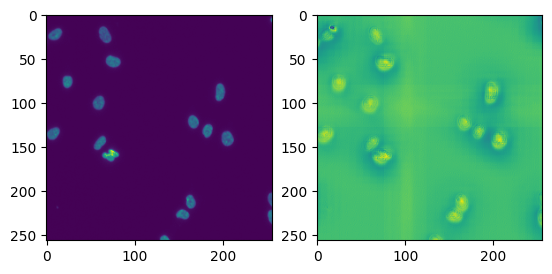

In [12]:
plt.subplot(1,2,1)
plt.imshow(imgs[2][0])
plt.subplot(1,2,2)
plt.imshow(mks[2][0])

In [13]:
print('Making cellpose model')
model = models.CellposeModel(model_type='nuclei',gpu=core.use_gpu())
print('Made cellpose model\n')

Making cellpose model
Made cellpose model



Getting reg data
len masks 100


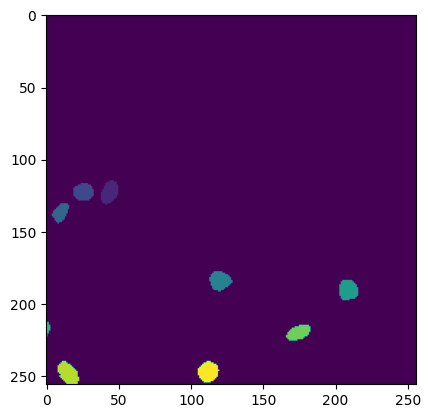

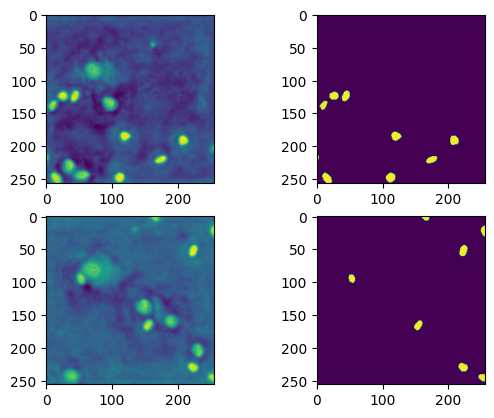

Got data



In [14]:
print('Getting reg data')
X, y = reg_data(imgs,model)
print('Got data\n')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [15]:
img = X_train[0]
xs = img.shape[0]//2  # division lines for the picture
ys = img.shape[1]//2
# now slice up the image (in a shape that works well with subplots)
splits = np.array([[img[0:xs, 0:ys], img[0:xs, ys:]], [img[xs:, 0:ys], img[xs:, ys:]]])

In [16]:
print(splits.shape)

(2, 2, 128, 128)


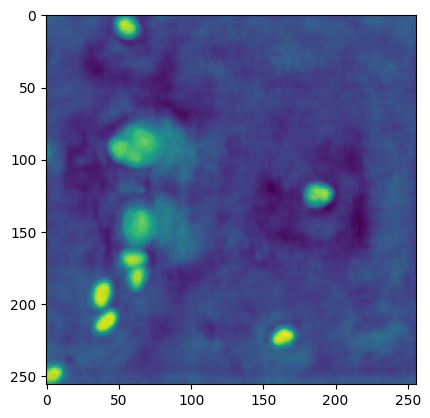

In [17]:
plt.imshow(X_train[0])

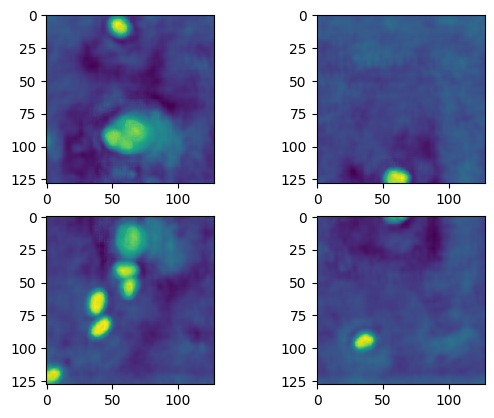

In [18]:
fig, axs = plt.subplots(2, 2)
for i in range(2):
    for j in range(2):
        axs[i][j].imshow(splits[i][j])

In [102]:
splits_sh = np.reshape(splits,(4,128,128))

In [19]:
def split_img(img):
    xs = img.shape[0]//2  # division lines for the picture
    ys = img.shape[1]//2
    # now slice up the image (in a shape that works well with subplots)
    splits = np.array([[img[0:xs, 0:ys], img[0:xs, ys:]], [img[xs:, 0:ys], img[xs:, ys:]]])
    splits_sh = np.reshape(splits,(4,128,128))
    return splits_sh

In [20]:
import cv2
def reconstruct_img(splits_sh):
    left = cv2.hconcat([splits_sh[0],splits_sh[1]])
    right = cv2.hconcat([splits_sh[2],splits_sh[3]])
    full = cv2.vconcat([left,right])
    return full

In [21]:
X_train_split = np.array([split_img(img) for img in X_train])
X_train_split = np.reshape(X_train_split,(X_train_split.shape[0]*X_train_split.shape[1],X_train_split.shape[-1],X_train_split.shape[-1]))

X_test_split = np.array([split_img(img) for img in X_test])
X_test_split = np.reshape(X_test_split,(X_test_split.shape[0]*X_test_split.shape[1],X_test_split.shape[-1],X_test_split.shape[-1]))

y_train_split = np.array([split_img(img) for img in y_train])
y_train_split = np.reshape(y_train_split,(y_train_split.shape[0]*y_train_split.shape[1],y_train_split.shape[-1],y_train_split.shape[-1]))

y_test_split = np.array([split_img(img) for img in y_test])
y_test_split = np.reshape(y_test_split,(y_test_split.shape[0]*y_test_split.shape[1],y_test_split.shape[-1],y_test_split.shape[-1]))

In [22]:
X_train_np = np.array([np.array(X_train_split[i]).flatten() for i in range(len(X_train_split))])
X_test_np = np.array([np.array(X_test_split[i]).flatten() for i in range(len(X_test_split))])
y_train_np = np.array([np.array(y_train_split[i]).flatten() for i in range(len(y_train_split))])
y_test_np = np.array([np.array(y_test_split[i]).flatten() for i in range(len(y_test_split))])

In [23]:
print(y_test_np.shape)

(80, 16384)


In [24]:
print('Training model')
reg = LinearRegression().fit(X_train_np[:2], y_train_np[:2])
print('Done training model')

Training model


KeyboardInterrupt: 

In [25]:
print(X_test_np.shape)
print(X_test_np[0].shape)

(80, 16384)
(16384,)


In [9]:
pred1 = reg.predict(X_test_np)
#pred2 = reg.predict(y_test_np[1])

NameError: name 'reg' is not defined

In [25]:
print(pred1.shape)

(2, 65536)


In [26]:
first_pred = pred1[0].reshape(256,256)
print(first_pred.shape)

(256, 256)


ValueError: cannot reshape array of size 16384 into shape (256,256)

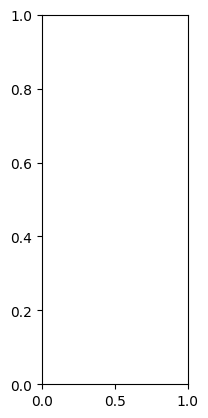

In [26]:
plt.subplot(1,3,1)
plt.imshow(X_test_np[0].reshape(256,256))
plt.subplot(1,3,2)
plt.imshow(np.flip(first_pred))
plt.subplot(1,3,3)
plt.imshow(y_test_np[0].reshape(256,256))

In [28]:
print(np.unique(first_pred))

[0.         0.3101211  0.31012112 0.31012118 0.6898788  1.        ]


In [56]:
print(y_test_np[0][0].astype('float32').dtype)

float32


In [34]:
import torch
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.current_device())

False
0


AssertionError: Torch not compiled with CUDA enabled

In [35]:
X_im = X_train[0]
y_im = y_train[0] #for now only doing on 1 img
M = 32
X_train_tiles = [X_im[x:x+M,y:y+M] for x in range(0,X_im.shape[0],M) for y in range(0,X_im.shape[1],M)]
y_train_tiles = [y_im[x:x+M,y:y+M] for x in range(0,y_im.shape[0],M) for y in range(0,y_im.shape[1],M)]

X_test_im = X_test[0]
y_test_im = y_test[0]
X_test_tiles = [X_test_im[x:x+M,y:y+M] for x in range(0,X_test_im.shape[0],M) for y in range(0,X_test_im.shape[1],M)]
y_test_tiles = [y_test_im[x:x+M,y:y+M] for x in range(0,y_test_im.shape[0],M) for y in range(0,y_test_im.shape[1],M)]

print(len(X_train_titles))
print(len(X_test_tiles))

X_train_tiles_np = np.array([np.array(X_train_tiles[i]).flatten() for i in range(len(X_train_tiles))])
y_train_tiles_np = np.array([np.array(y_train_tiles[i]).flatten() for i in range(len(y_train_tiles))])
X_test_tiles_np = np.array([np.array(X_test_tiles[i]).flatten() for i in range(len(X_test_tiles))])
y_test_tiles_np = np.array([np.array(y_test_tiles[i]).flatten() for i in range(len(y_test_tiles))])

64


In [153]:
print(X_train_np[0].shape)

(16384,)


In [41]:
print(X_train_tiles_np.shape)

(64, 1024)


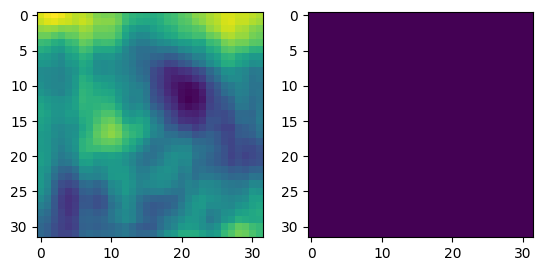

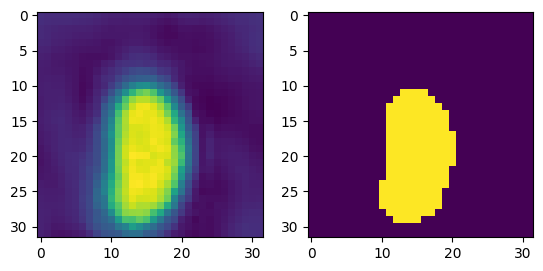

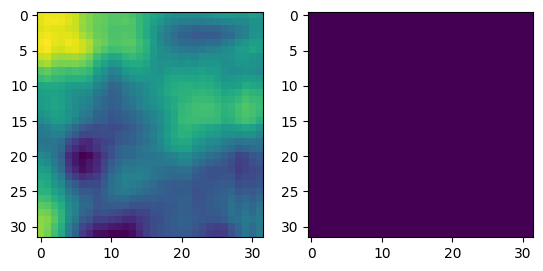

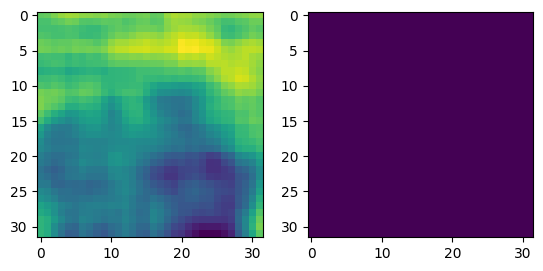

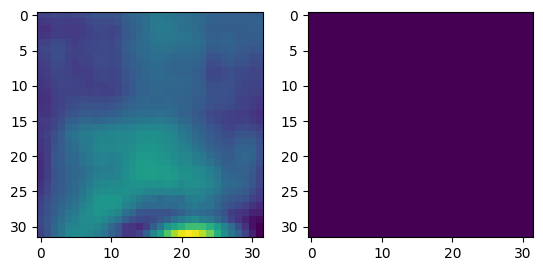

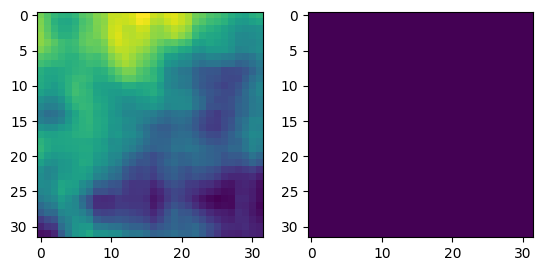

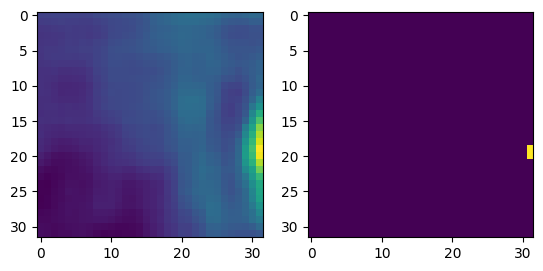

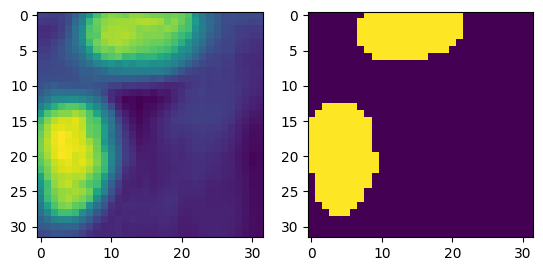

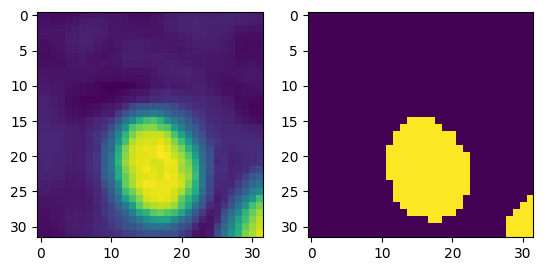

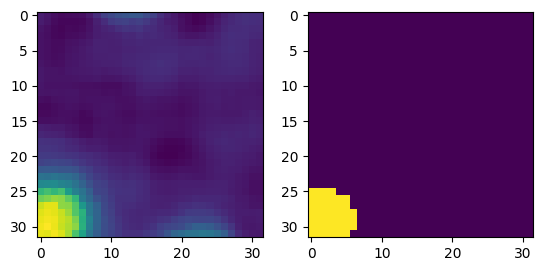

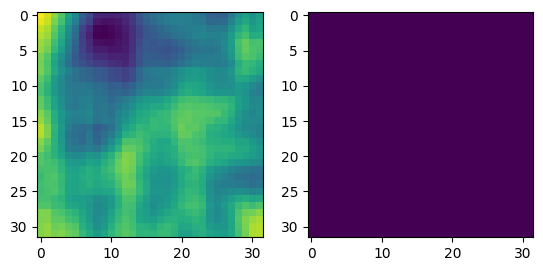

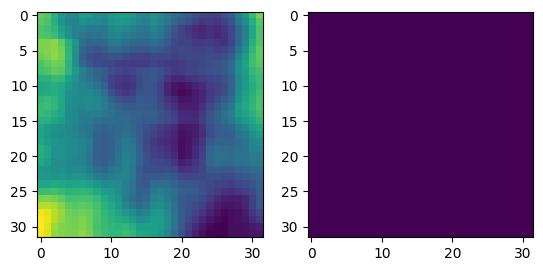

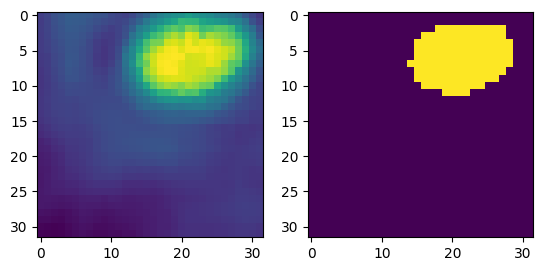

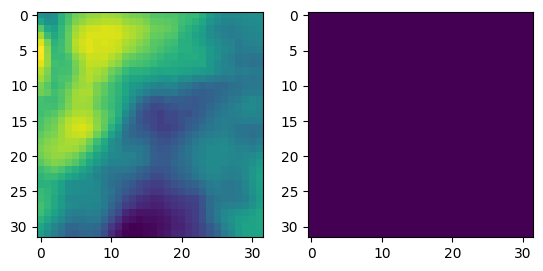

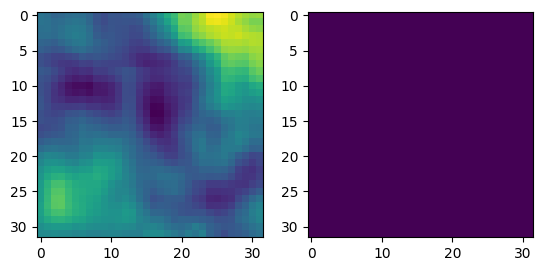

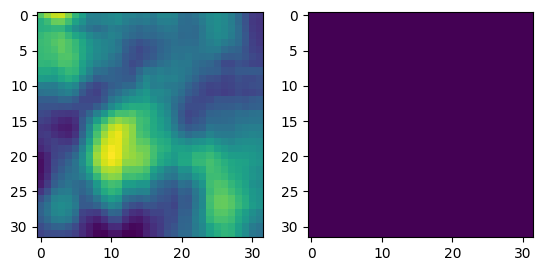

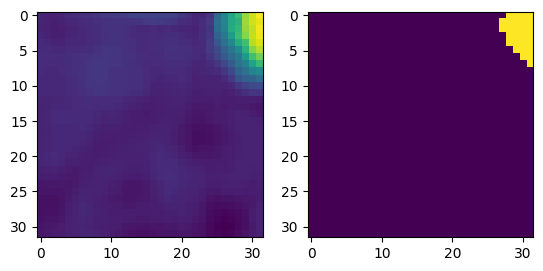

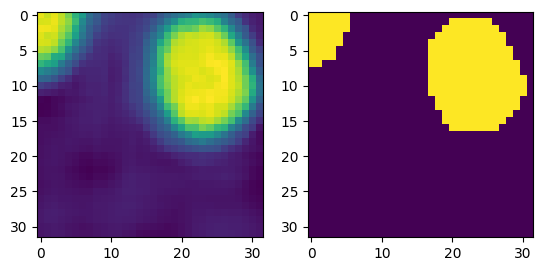

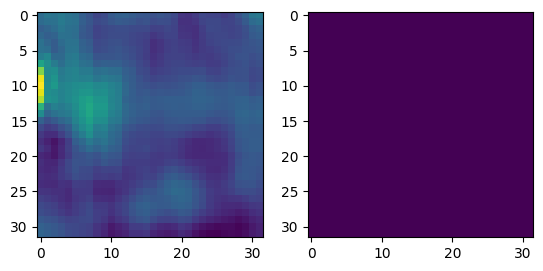

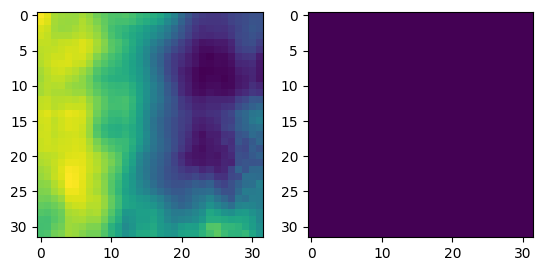

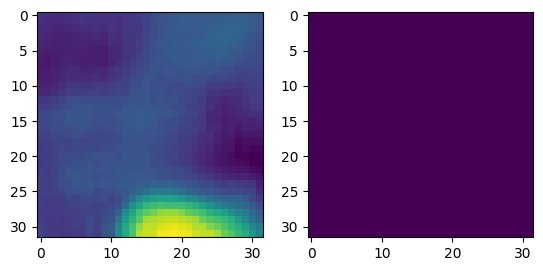

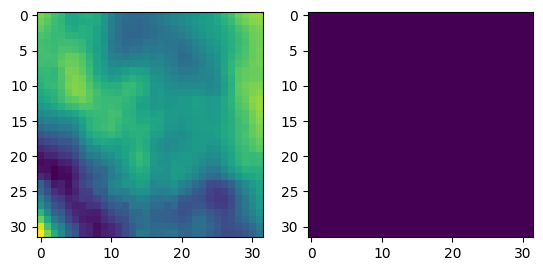

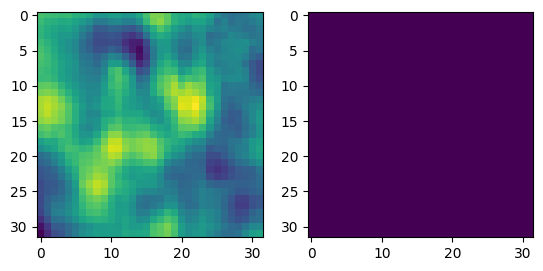

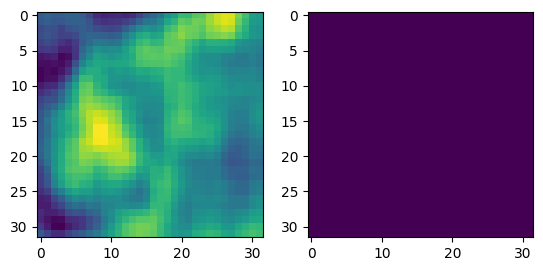

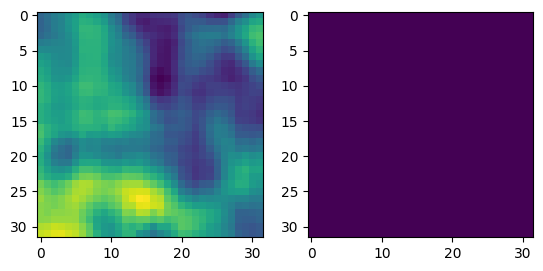

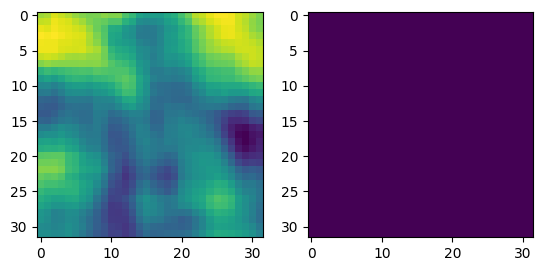

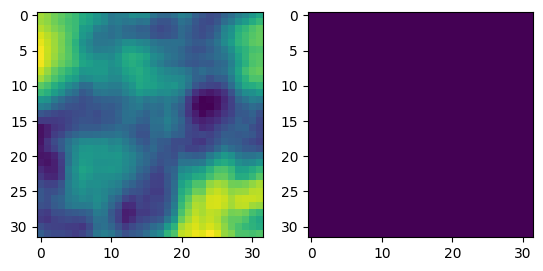

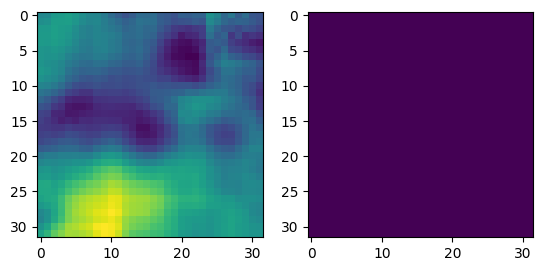

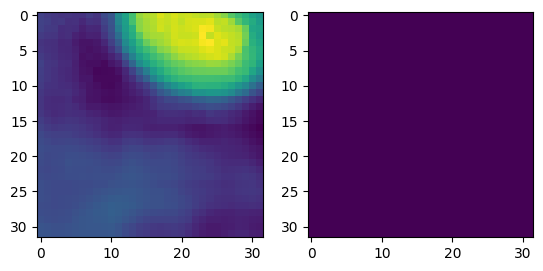

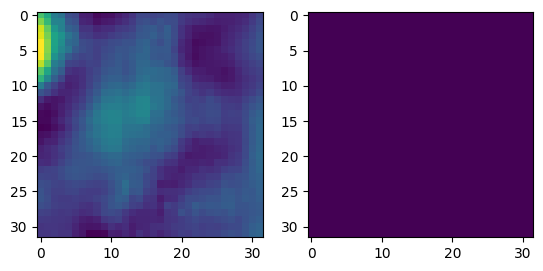

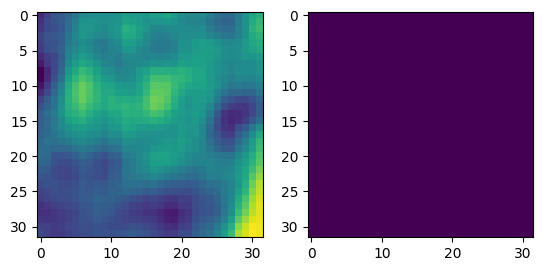

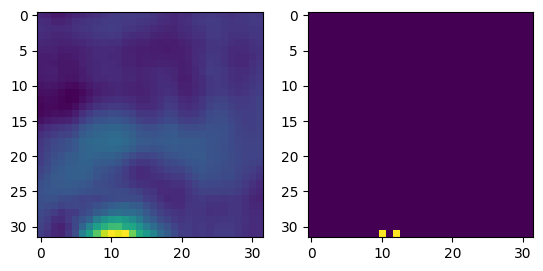

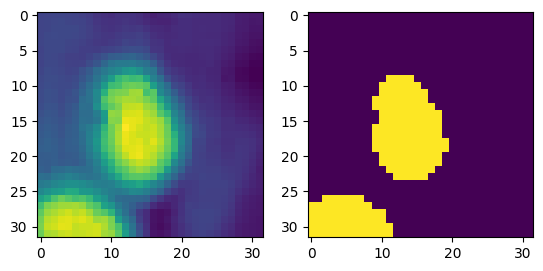

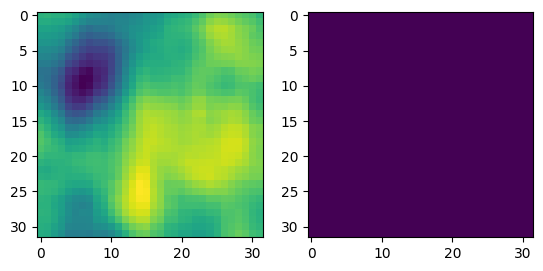

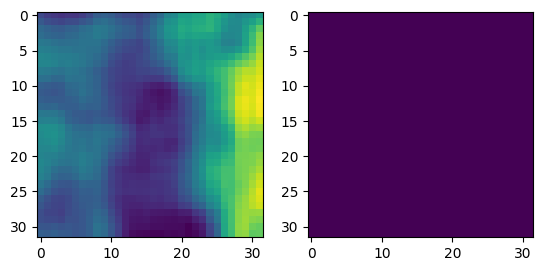

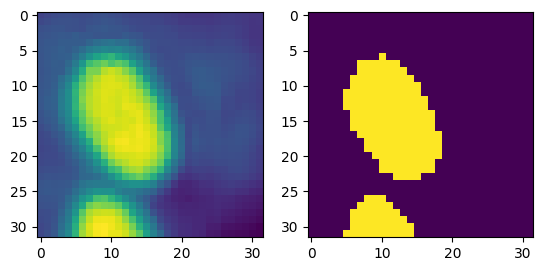

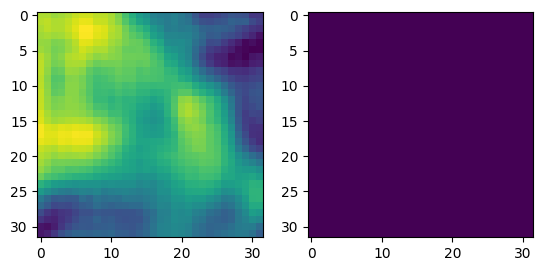

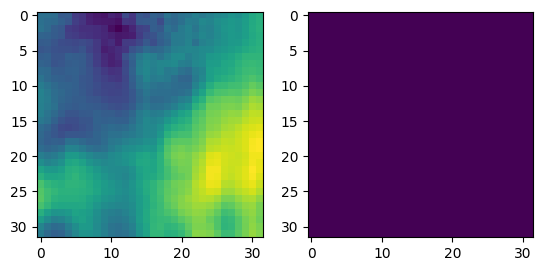

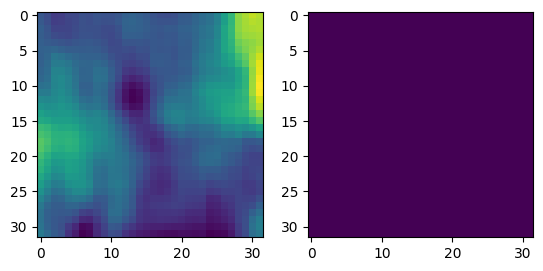

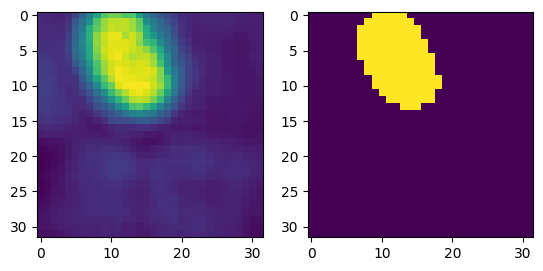

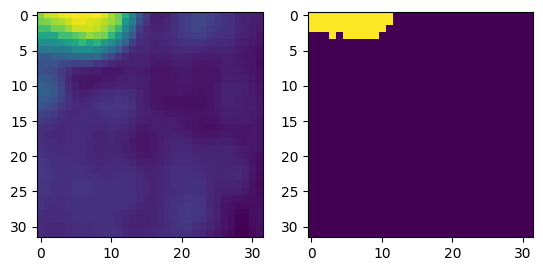

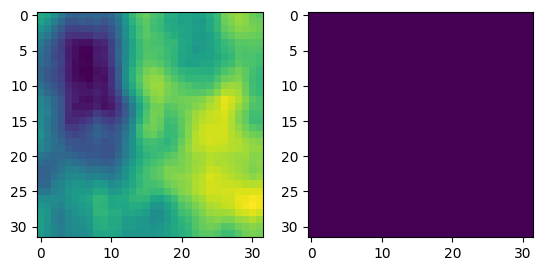

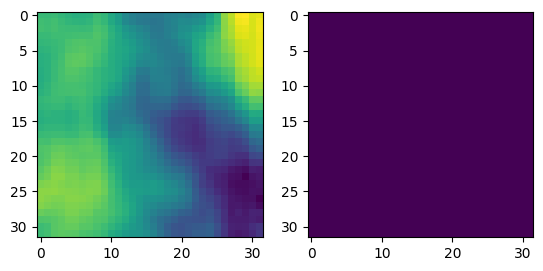

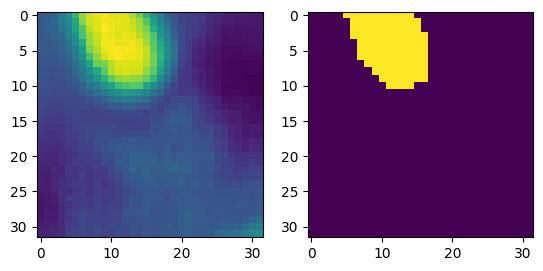

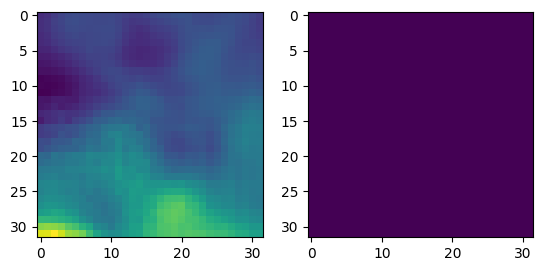

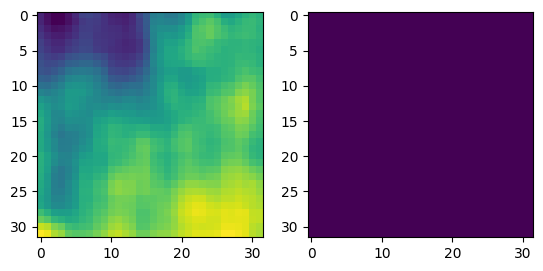

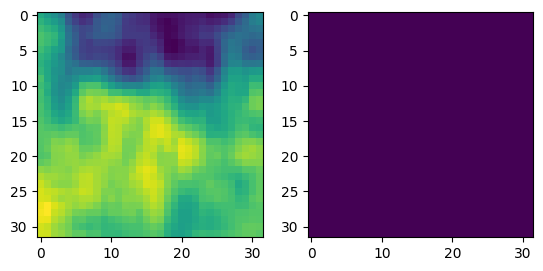

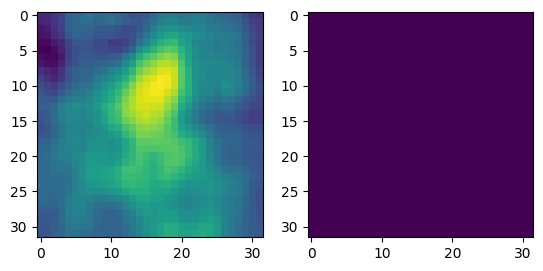

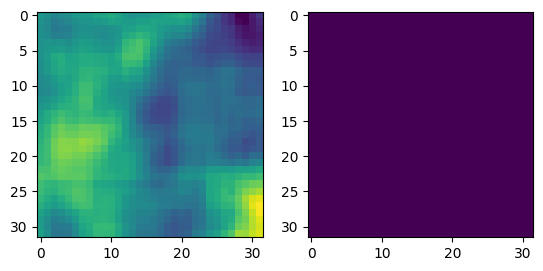

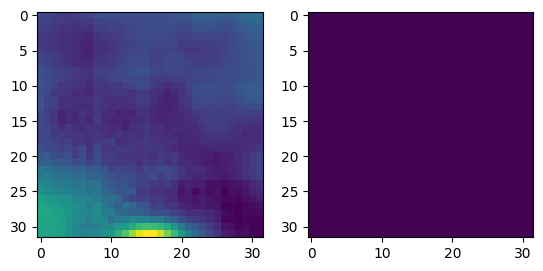

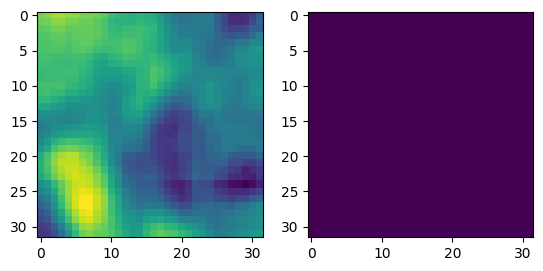

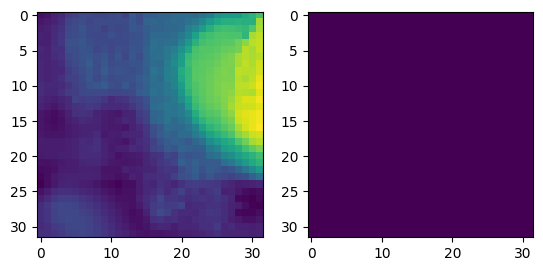

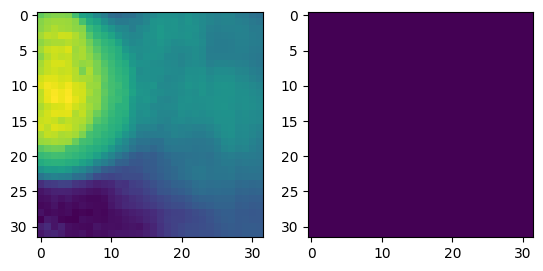

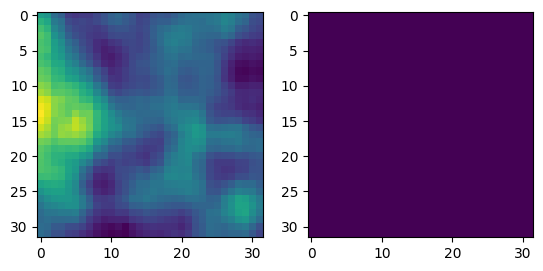

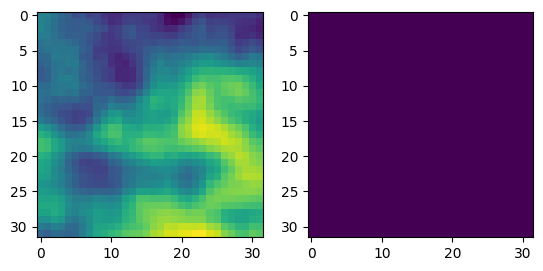

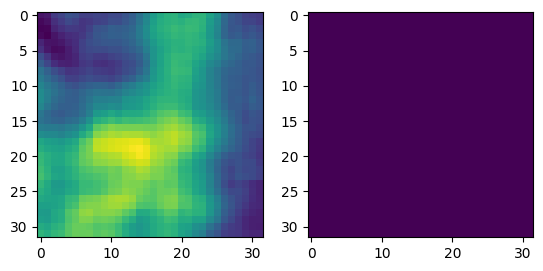

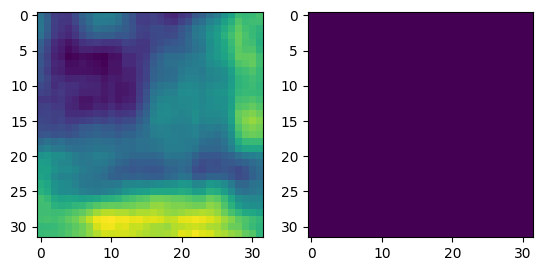

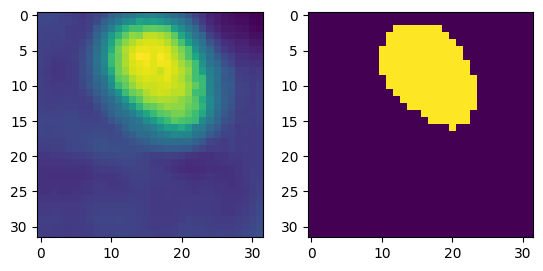

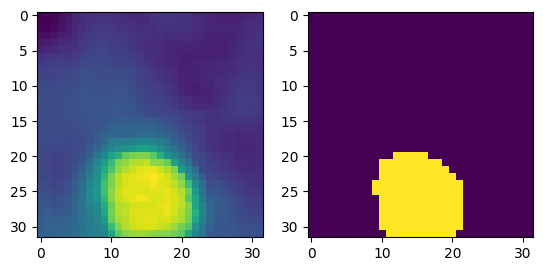

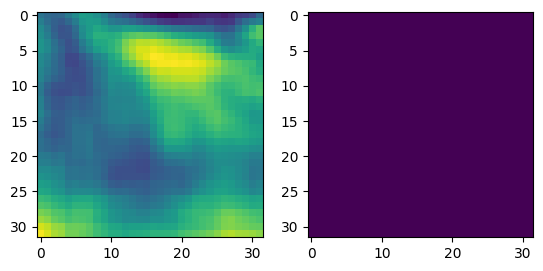

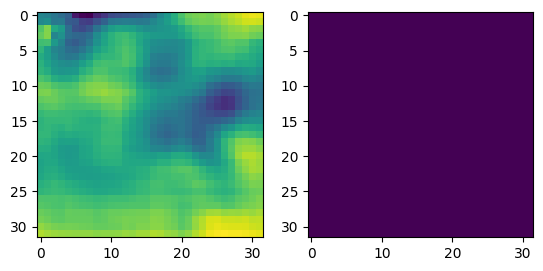

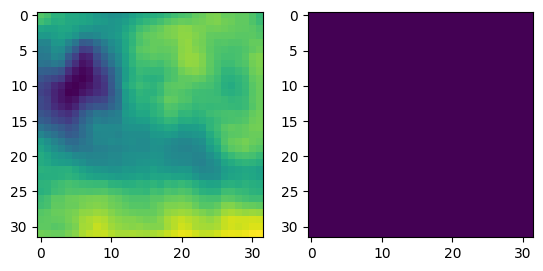

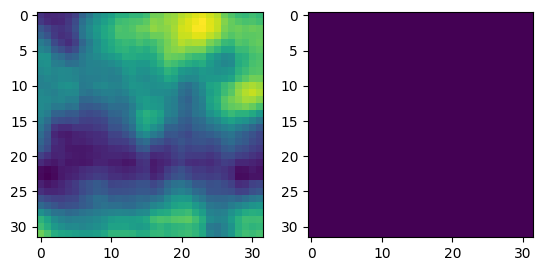

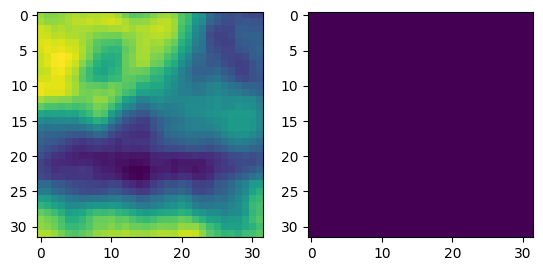

In [39]:

for i in range(len(X_train_tiles)):
    plt.subplot(1,2,1)
    plt.imshow(X_train_tiles[i])
    plt.subplot(1,2,2)
    plt.imshow(y_train_tiles[i])
    plt.show()

In [38]:
print(len(X_train_np))

320


In [40]:
import torch.nn.functional as F
import torch.nn as nn

class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        
        return 1 - dice

In [41]:
import torch
import torch.nn as nn

class LinearRegressionModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LinearRegressionModel, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)  

    def forward(self, x):
        out = self.linear(x)
        #output = torch.sigmoid(out)
        #output = torch.round(output)
        #print('out dtype:',out.dtype)
        return out

input_dim = 16384
output_dim = 16384

model = LinearRegressionModel(input_dim, output_dim)
#model.to("cuda:0")

#criterion = nn.BCEWithLogitsLoss()
criterion = DiceLoss()

learning_rate = 0.00001

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

epochs = 1000

for epoch in range(epochs):
    epoch += 1
    # Convert numpy array to torch Variable
    #inputs = torch.from_numpy(X_train_np).to("cuda:0")
    #labels = torch.from_numpy(y_train_np.astype('float32')).to("cuda:0")
    inputs = torch.from_numpy(X_train_np[:100])
    labels = torch.from_numpy(y_train_np[:100].astype('float32'))

    # Clear gradients w.r.t. parameters
    optimizer.zero_grad() 

    # Forward to get output
    outputs = model(inputs)

    # Calculate Loss
    loss = criterion(outputs, labels)

    test_dice_score = 0
    with torch.no_grad():
        # set the model in evaluation mode
        model.eval()
        # loop over the validation set
        for i in range(len(X_test_np)):
            x = X_test_np[i]
            gt = y_test_np[i]
            #NEED TO SIGMOID THE PRED FIRST LIKE WE DO IN THE DICE LOSS
            pred = np.where(model(torch.from_numpy(x)).cpu().detach().numpy()>0.5,0,1)
            #pred = pred.cpu().detach().numpy()
            test_dice_score += np.sum(pred[gt==1])*2.0 / (np.sum(pred) + np.sum(gt))

    # Getting gradients w.r.t. parameters
    loss.backward()

    # Updating parameters
    optimizer.step()

    print('epoch {}, loss {}, test dice {}'.format(epoch, loss.item(), test_dice_score))


/opt/anaconda3/envs/unetenv/lib/python3.8/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


epoch 1, loss 0.9110808968544006, test dice 6.670454563054041
epoch 2, loss 0.9015107750892639, test dice 6.636219012053554
epoch 3, loss 0.893745481967926, test dice 6.636368066537629
epoch 4, loss 0.887552797794342, test dice 6.640805904714177


KeyboardInterrupt: 

In [228]:
model.eval()
pred1 = model(torch.from_numpy(X_test_np).to("cuda:0"))

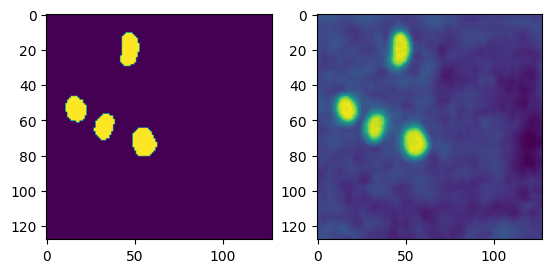

In [229]:
ori = X_train_np[0]
x = ori
x = torch.from_numpy(x)
x = x.to("cuda:0")
y_pred = model(x)
y_pred = y_pred.cpu().detach().numpy()
y_pred = np.reshape(y_pred,(128,128))


plt.subplot(1,2,1)
plt.imshow(np.where(y_pred>0.5,1,0))
plt.subplot(1,2,2)
plt.imshow(np.reshape(ori,(128,128)))

dice 1.0


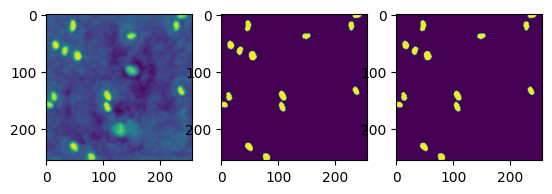

In [232]:
pred_from_train_1 = np.reshape( model(torch.from_numpy(X_train_np[0]).to("cuda:0")) .cpu().detach().numpy(),(128,128))
pred_from_train_2 = np.reshape(model(torch.from_numpy(X_train_np[1]).to("cuda:0")) .cpu().detach().numpy(),(128,128))
pred_from_train_3 = np.reshape(model(torch.from_numpy(X_train_np[2]).to("cuda:0")) .cpu().detach().numpy(),(128,128))
pred_from_train_4 = np.reshape(model(torch.from_numpy(X_train_np[3]).to("cuda:0")) .cpu().detach().numpy(),(128,128))

pred = reconstruct_img([pred_from_train_1,pred_from_train_2,pred_from_train_3,pred_from_train_4])

plt.subplot(1,3,1)
original_img = reconstruct_img(np.reshape(X_train_np[:4],(4,128,128)))
plt.imshow(original_img)
plt.subplot(1,3,2)
predicition_bin = np.where(pred>0.5,1,0)
plt.imshow(predicition_bin)
plt.subplot(1,3,3)
groundtruth = reconstruct_img(np.reshape(y_train_np[:4],(4,128,128)))
plt.imshow(groundtruth)

print('dice',np.sum(predicition_bin[groundtruth==1])*2.0 / (np.sum(predicition_bin) + np.sum(groundtruth)))

dice 0.05063291139240506


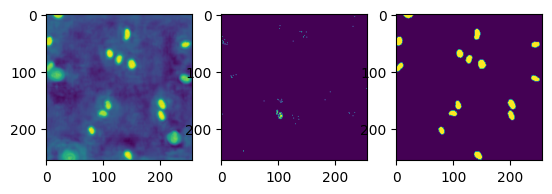

In [233]:
pred_from_train_1 = np.reshape( model(torch.from_numpy(X_test_np[0]).to("cuda:0")) .cpu().detach().numpy(),(128,128))
pred_from_train_2 = np.reshape(model(torch.from_numpy(X_test_np[1]).to("cuda:0")) .cpu().detach().numpy(),(128,128))
pred_from_train_3 = np.reshape(model(torch.from_numpy(X_test_np[2]).to("cuda:0")) .cpu().detach().numpy(),(128,128))
pred_from_train_4 = np.reshape(model(torch.from_numpy(X_test_np[3]).to("cuda:0")) .cpu().detach().numpy(),(128,128))

pred = reconstruct_img([pred_from_train_1,pred_from_train_2,pred_from_train_3,pred_from_train_4])

plt.subplot(1,3,1)
original_img = reconstruct_img(np.reshape(X_test_np[:4],(4,128,128)))
plt.imshow(original_img)
plt.subplot(1,3,2)
predicition_bin = np.where(pred>0.5,1,0)
plt.imshow(predicition_bin)
plt.subplot(1,3,3)
groundtruth = reconstruct_img(np.reshape(y_test_np[:4],(4,128,128)))
plt.imshow(groundtruth)

print('dice',np.sum(predicition_bin[groundtruth==1])*2.0 / (np.sum(predicition_bin) + np.sum(groundtruth)))

torch.Size([8, 16384])


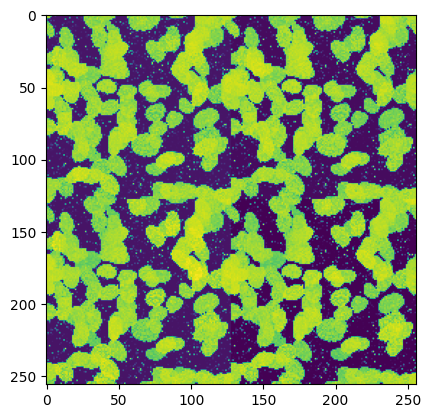

In [182]:
print(pred1.shape)

first_pred = reconstruct_img(np.reshape(pred1.cpu().detach().numpy()[:4],(4,128,128)))

plt.subplot(1,2,1)
plt.imshow(first_pred)
plt.subplot(1,2,2)
plt.imshow(reconstruct_img(np.reshape))

#print(np.reshape(pred1.cpu().detach().numpy(),(256,256)))
#plt.imshow(np.reshape(pred1.cpu().detach().numpy(),(256,256)))

In [176]:
import cv2
def reconstruct_img_after(splits_sh):
    left = cv2.hconcat([splits_sh[0],splits_sh[1]])
    right = cv2.hconcat([splits_sh[2],splits_sh[3]])
    full = cv2.vconcat([left,right])
    return full

torch.Size([4, 16384])


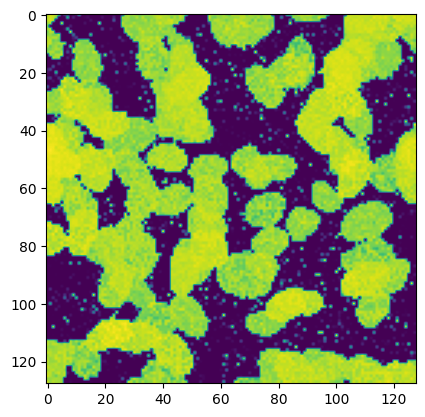

In [175]:
test = pred1[0].cpu().detach().numpy()
test = np.reshape(test,(128,128))
plt.imshow(test)

In [167]:
print(np.unique(test,return_counts=True))

(array([0., 1.], dtype=float32), array([8122, 8262], dtype=int64))


In [26]:
print(pred1.to("cpu"))

tensor([nan], grad_fn=<ToCopyBackward0>)


In [ ]:
pred1 = reg.predict(y_test_np[0])
pred2 = reg.predict(y_test_np[1])